In [2]:
import pandas as pd
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable

In [3]:
!pip install pulp

In [4]:
# Load the dataset
data = pd.read_csv("/kaggle/input/car-sales-report/Car Sales.xlsx - car_data.csv") 

# Preview the first few rows of the dataset
data.head()


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


# **Data Cleaning**

**Preprocess the Data**

****1.Handle missing values:****

* Drop rows or columns with excessive missing data.
* Impute missing values using mean/median for numeric data or mode for categorical data.

**Ensure proper data types:**


* Convert Date to a datetime format.
* Convert categorical columns like Gender, Dealer_Region, Company, and Model to categorical types for better analysis.


In [5]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing values (example for numeric and categorical columns)
data['Annual Income'] = data['Annual Income'].fillna(data['Annual Income'].median())
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])

# Ensure categorical data types
categorical_cols = ['Gender', 'Dealer_Region', 'Company', 'Model', 'Color']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Check the cleaned data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Car_id         23906 non-null  object        
 1   Date           23906 non-null  datetime64[ns]
 2   Customer Name  23905 non-null  object        
 3   Gender         23906 non-null  category      
 4   Annual Income  23906 non-null  int64         
 5   Dealer_Name    23906 non-null  object        
 6   Company        23906 non-null  category      
 7   Model          23906 non-null  category      
 8   Engine         23906 non-null  object        
 9   Transmission   23906 non-null  object        
 10  Color          23906 non-null  category      
 11  Price ($)      23906 non-null  int64         
 12  Dealer_No      23906 non-null  object        
 13  Body Style     23906 non-null  object        
 14  Phone          23906 non-null  int64         
 15  Dealer_Region  2390

# Market Analysis
****Evaluate overall trends and regional variations in car sales to assess manufacturer performance, model preferences, and demographic insights.****

# Supply Chain and Inventory Optimization

**Linear Programming (LP) problem to minimize the total transportation cost while adhering to supply and demand constraints.**

1. Dealers: Multiple dealerships are considered as suppliers of cars.
2. Regions: Different regions represent the customers that demand cars.
3. Costs: A cost matrix is defined that specifies the transportation cost from each dealer to each region.
4. Supply: The available number of cars at each dealership.
5. Demand: The required number of cars for each region.


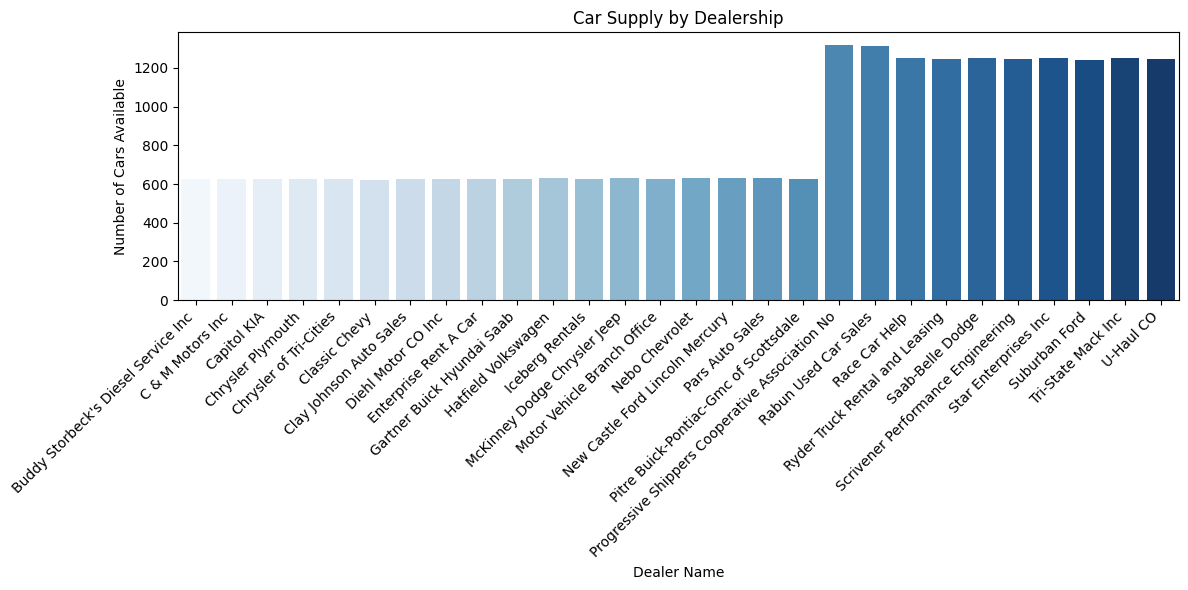

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert supply dictionary to DataFrame
supply_df = pd.DataFrame(list(supply.items()), columns=['Dealer_Name', 'Supply'])

# Plot
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility
sns.barplot(x='Dealer_Name', y='Supply', data=supply_df, palette='Blues')

# Rotate x-axis labels and adjust spacing
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
plt.title('Car Supply by Dealership')
plt.xlabel('Dealer Name')
plt.ylabel('Number of Cars Available')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()


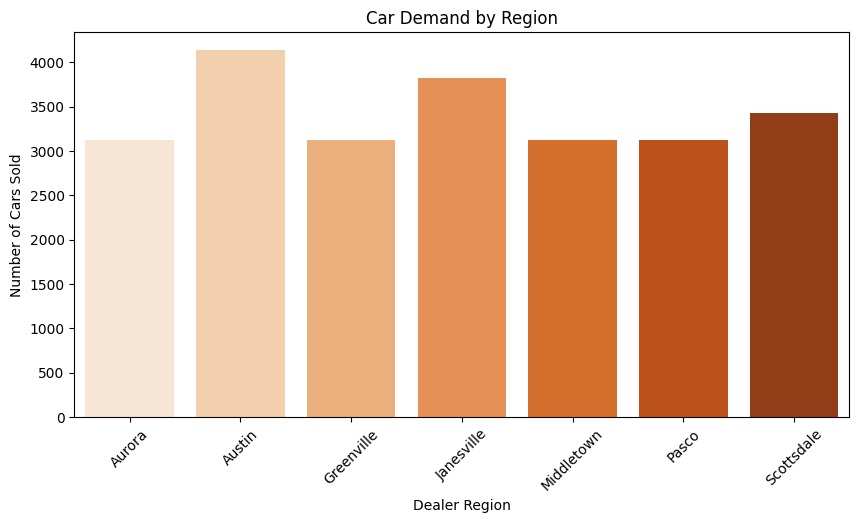

In [23]:
# Convert demand dictionary to DataFrame
demand_df = pd.DataFrame(list(demand.items()), columns=['Dealer_Region', 'Demand'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Dealer_Region', y='Demand', data=demand_df, palette='Oranges')
plt.xticks(rotation=45)
plt.title('Car Demand by Region')
plt.xlabel('Dealer Region')
plt.ylabel('Number of Cars Sold')
plt.show()


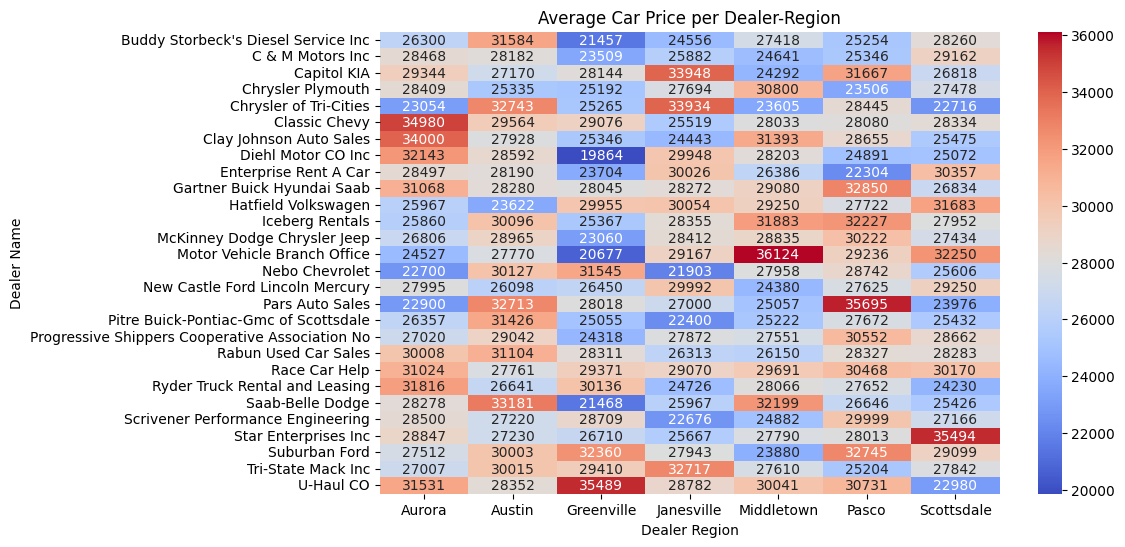

In [24]:
#Cost Visualization
# Convert costs dictionary to DataFrame
cost_df = pd.DataFrame.from_dict(costs, orient='index', columns=['Average Price'])
cost_df.index = pd.MultiIndex.from_tuples(cost_df.index, names=['Dealer_Name', 'Dealer_Region'])
cost_df = cost_df.reset_index()

# Pivot for heatmap
cost_pivot = cost_df.pivot(index='Dealer_Name', columns='Dealer_Region', values='Average Price')

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cost_pivot, cmap="coolwarm", annot=True, fmt=".0f")
plt.title('Average Car Price per Dealer-Region')
plt.xlabel('Dealer Region')
plt.ylabel('Dealer Name')
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


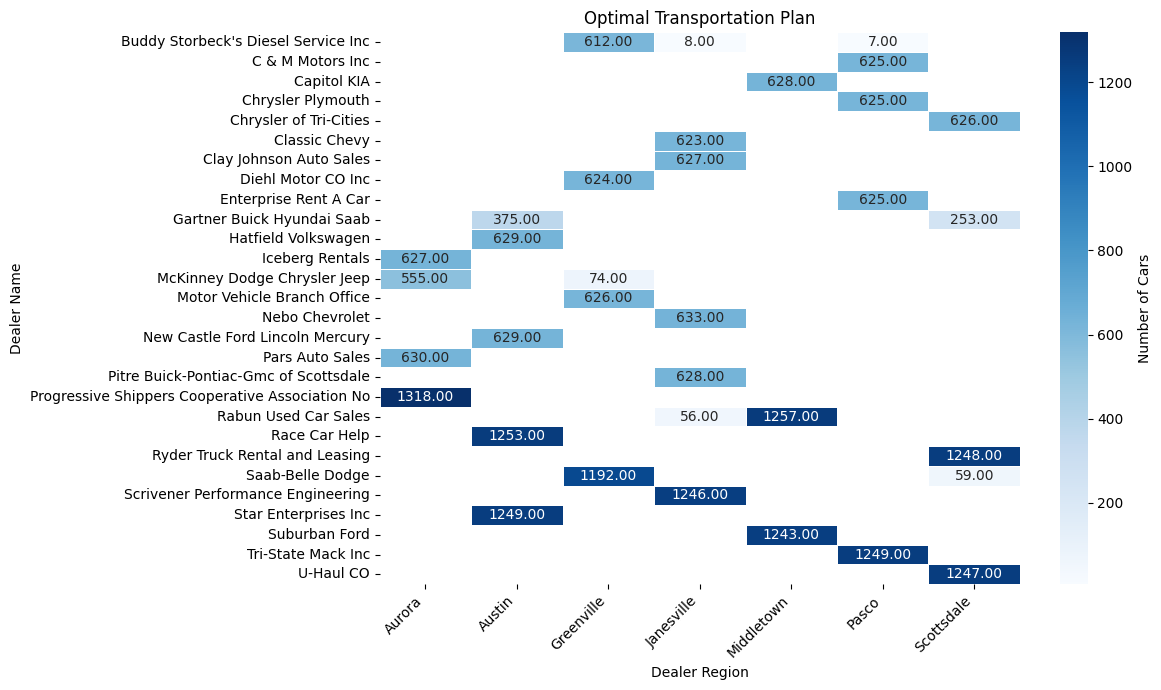

Total Transportation Cost: $581,994,603.69


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, value

# Define the problem: Minimize transportation costs
problem = LpProblem("Car_Distribution_Optimization", LpMinimize)

# Define decision variables: how many cars from each dealer to each region
x = LpVariable.dicts("Cars", [(dealer, region) for dealer in dealerships for region in regions], 
                     lowBound=0, cat='Continuous')

# Objective function: Minimize transportation costs (cost * number of cars)
problem += lpSum([x[dealer, region] * costs.get((dealer, region), 0) for dealer in dealerships for region in regions])

# Constraints: Supply at dealerships (do not exceed the available cars at each dealer)
for dealer in dealerships:
    problem += lpSum([x[dealer, region] for region in regions]) <= supply.get(dealer, 0), f"Supply_{dealer}"

# Constraints: Demand in regions (must meet or exceed demand)
for region in regions:
    problem += lpSum([x[dealer, region] for dealer in dealerships]) >= demand.get(region, 0), f"Demand_{region}"

# Solve the problem
problem.solve()

# Extract optimal results for visualization
transport_plan = []
for dealer in dealerships:
    for region in regions:
        value_shipped = x[dealer, region].varValue
        if value_shipped > 0:  # Only consider non-zero shipments
            transport_plan.append({
                'Dealer_Name': dealer,
                'Dealer_Region': region,
                'Cars_Shipped': value_shipped
            })

# Convert results to a DataFrame
transport_df = pd.DataFrame(transport_plan)

# Create a heatmap for visualization
heatmap_data = transport_df.pivot(index="Dealer_Name", columns="Dealer_Region", values="Cars_Shipped")

# Set up the figure for the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f", cbar_kws={'label': 'Number of Cars'}, linewidths=0.5)
plt.title("Optimal Transportation Plan")
plt.xlabel("Dealer Region")
plt.ylabel("Dealer Name")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the heatmap
plt.tight_layout()
plt.show()

# Output the total transportation cost
total_cost = value(problem.objective)
print(f"Total Transportation Cost: ${total_cost:,.2f}")


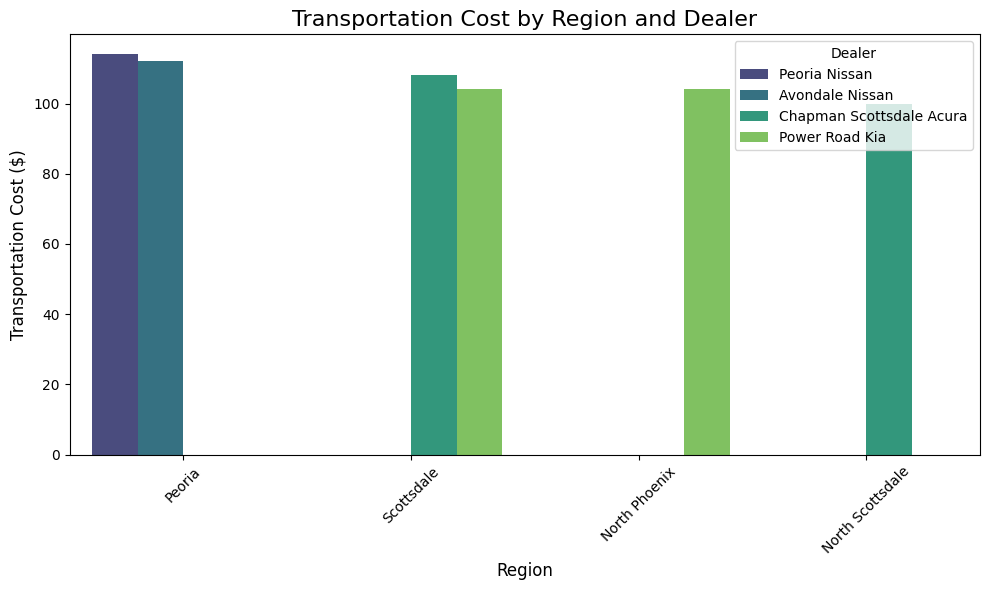

High Transportation Cost Regions & Dealers:
             Region                    Dealer  Transportation_Cost
0            Peoria             Peoria Nissan                  114
1            Peoria           Avondale Nissan                  112
2        Scottsdale  Chapman Scottsdale Acura                  108
3        Scottsdale            Power Road Kia                  104
4     North Phoenix            Power Road Kia                  104
5  North Scottsdale  Chapman Scottsdale Acura                  100


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'Region': ['Peoria', 'Peoria', 'Scottsdale', 'Scottsdale', 'North Phoenix', 'North Scottsdale'],
    'Dealer': ['Peoria Nissan', 'Avondale Nissan', 'Chapman Scottsdale Acura', 'Power Road Kia', 
               'Power Road Kia', 'Chapman Scottsdale Acura'],
    'Transportation_Cost': [114, 112, 108, 104, 104, 100]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Visualizing the transportation costs in a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Region', y='Transportation_Cost', hue='Dealer', palette="viridis")

# Adding labels and title
plt.title('Transportation Cost by Region and Dealer', fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Transportation Cost ($)', fontsize=12)
plt.xticks(rotation=45)

# Displaying the plot
plt.tight_layout()
plt.show()

# Display high-cost regions and dealers in tabular form
high_cost_df = df.sort_values(by='Transportation_Cost', ascending=False)
print("High Transportation Cost Regions & Dealers:")
print(high_cost_df)
